Credits:
- https://gaussianprocess.org/gpml/chapters/RW.pdf
- https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
df = pd.read_csv("co2.csv")

In [3]:
df

,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
780,2023,3,2023.2083,420.98,419.53,30,0.74,0.26
781,2023,4,2023.2917,423.36,420.69,28,0.60,0.22
782,2023,5,2023.3750,424.00,420.55,31,0.69,0.24
783,2023,6,2023.4583,423.68,421.18,29,0.54,0.19


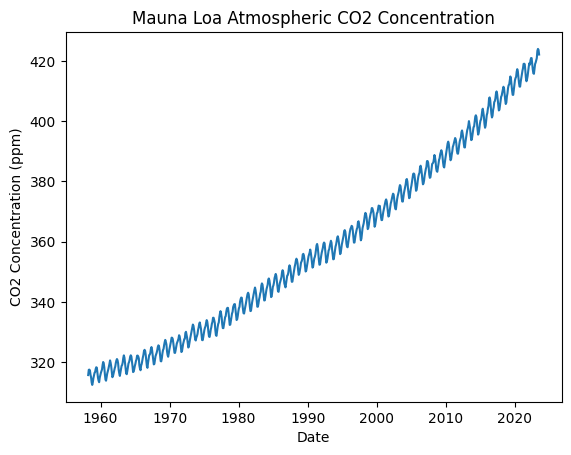

In [4]:
import matplotlib.pyplot as plt

plt.title('Mauna Loa Atmospheric CO2 Concentration')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.plot(df['decimal_date'], df['average'])

In [5]:
cutoff = 2000
train_x = torch.tensor(df.query(f"decimal_date < {cutoff}")["decimal_date"].values)
train_y = torch.tensor(df.query(f"decimal_date <{cutoff}")["average"].values)
test_x = torch.tensor(df.query(f"decimal_date >= {cutoff}")["decimal_date"].values)
test_y = torch.tensor(df.query(f"decimal_date >= {cutoff}")["average"].values)

In [6]:
mean_y = train_y.mean()
std_y = train_y.std()
train_y = train_y - mean_y
train_y = train_y / std_y
test_y = test_y - mean_y
test_y = test_y / std_y

In [7]:
len(train_x)

502

In [8]:
import  gpytorch.kernels as k

In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = (
            k.ScaleKernel(k.RBFKernel()) 
            + k.ScaleKernel(k.RBFKernel()*k.PeriodicKernel())
            + k.ScaleKernel(k.RQKernel())
            + k.ScaleKernel(k.RBFKernel())
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)



In [10]:
model.covar_module.kernels

ModuleList(
  (0): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (1): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (1): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
  (2): ScaleKernel(
    (base_kernel): RQKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_alpha_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (3): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

## Hyperparameter initialization

In [11]:
model.covar_module.kernels[0].outputscale = 50
model.covar_module.kernels[0].base_kernel.lengthscale = 50

In [12]:
model.covar_module.kernels[1].outputscale = .5
model.covar_module.kernels[1].base_kernel.kernels[0].lengthscale = 100
model.covar_module.kernels[1].base_kernel.kernels[1].lengthscale = 1
model.covar_module.kernels[1].base_kernel.kernels[1].period_length = 1


In [13]:
model.covar_module.kernels[2].outputscale = 0.5
model.covar_module.kernels[2].base_kernel.lengthscale = 1
model.covar_module.kernels[2].base_kernel.alpha = 1

In [14]:
model.covar_module.kernels[3].outputscale = 0.1
model.covar_module.kernels[3].base_kernel.lengthscale = 0.1

In [15]:
# Use gpu
train_x = train_x.cuda()
train_y = train_y.cuda()
test_x = test_x.cuda()
test_y = test_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()


In [16]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

parameters = set(model.parameters())
parameters = parameters - {model.covar_module.kernels[1].base_kernel.kernels[1].raw_period_length}

In [17]:
# Use the adam optimizer
optimizer = torch.optim.Adam(parameters, lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

    print(f"Iter: {i}, Loss: {loss.item()}")


Iter: 0, Loss: 0.8969307416862982
Iter: 1, Loss: 0.855003046038454
Iter: 2, Loss: 0.8125809975841102
Iter: 3, Loss: 0.769659159892345
Iter: 4, Loss: 0.7262331928562845
Iter: 5, Loss: 0.6823000251545299
Iter: 6, Loss: 0.6378586988039683
Iter: 7, Loss: 0.5929103185377848
Iter: 8, Loss: 0.5474585319789708
Iter: 9, Loss: 0.5015097564814711
Iter: 10, Loss: 0.45507314359303536
Iter: 11, Loss: 0.4081599281965606
Iter: 12, Loss: 0.3607824284757163
Iter: 13, Loss: 0.31295342520486685
Iter: 14, Loss: 0.2646861640744273
Iter: 15, Loss: 0.2159952567627971
Iter: 16, Loss: 0.16689804499327238
Iter: 17, Loss: 0.11741609983987965
Iter: 18, Loss: 0.06757528832221217
Iter: 19, Loss: 0.0174059319473672
Iter: 20, Loss: -0.03305922497655518
Iter: 21, Loss: -0.08378554069040567
Iter: 22, Loss: -0.13473906520207163
Iter: 23, Loss: -0.1858859942543423
Iter: 24, Loss: -0.23719399518166795
Iter: 25, Loss: -0.2886317280505003
Iter: 26, Loss: -0.3401692591000503
Iter: 27, Loss: -0.3917782872682248
Iter: 28, Loss:

In [18]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [19]:
train_y = train_y * std_y + mean_y
test_y = test_y * std_y + mean_y
mean = mean * std_y + mean_y
lower = lower * std_y + mean_y
upper = upper * std_y + mean_y

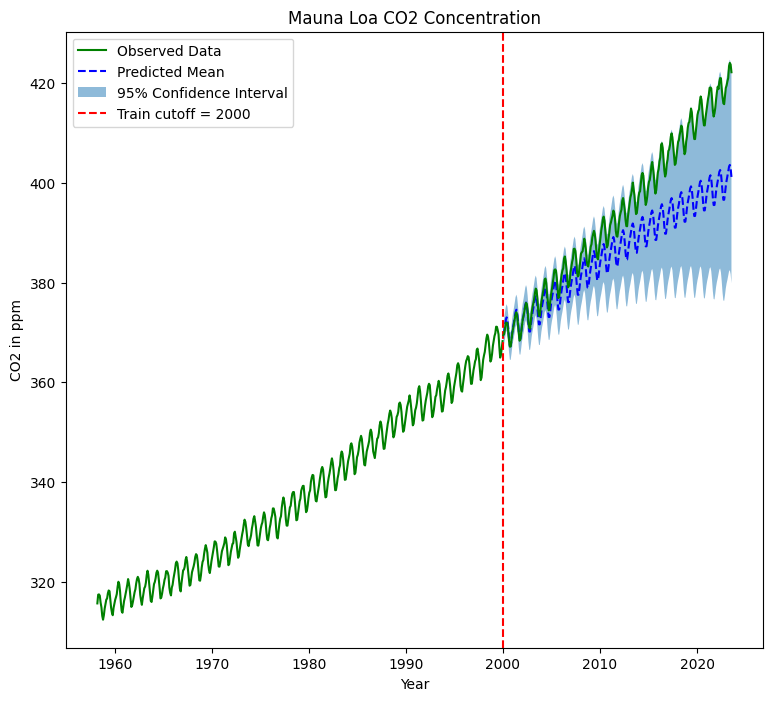

In [21]:
with torch.no_grad():
   # Initialize plot
   f, ax = plt.subplots(1, 1, figsize=(9, 8))

   # Plot training data as black stars
   ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'g')
   # Plot predictive means as blue line
   ax.plot(test_x.cpu().numpy(), mean.cpu().numpy(), 'b', linestyle='dashed')
   # Shade between the lower and upper confidence bounds
   ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
   ax.axvline(x=cutoff, color='r', linestyle='--')
   ax.plot(test_x.cpu().numpy(), test_y.cpu().numpy(), 'g')
   ax.legend(['Observed Data', 'Predicted Mean', '95% Confidence Interval',  f"Train cutoff = {cutoff}"])
   ax.set_title('Mauna Loa CO2 Concentration')
   ax.set_xlabel('Year')
   ax.set_ylabel('CO2 in ppm')